# TensorRT Engine Explorer Tutorial

Use this notebook to learn how to use `trex` to explore the structure and characteristics of a TensorRT Engine plan.
Starting with TensorRT 8.2, engine-plan graph and profiling data can be exported to JSON files.  `trex` loads these files and queries their content using a simple API that wraps Pandas' API

## 1. Create Engine Plan And Profiling JSON Files

Using `trtexec` it is easy to create the plan graph and profiling JSON files.  Three flags are required:
```
 --exportProfile=$profile_json
 --exportLayerInfo=$graph_json
 --profilingVerbosity=detailed
```

A utility Python script `utils/process_engine.py` can be used to create the JSON files. This script executes `trtexec` and therefore the script can only be invoked within an environment that has `trtexec` installed and included in `$PATH`.

In [1]:
# !python3 ../utils/process_engine.py ../tests/inputs/mobilenet.qat.onnx ../tests/inputs best

## 2. Load JSON Files

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
module_path = os.path.abspath(os.path.join('.'))
from trex import *

# Configure a wider output (for the wide graphs)
set_wide_display()

# Choose an engine file to load.  This notebook assumes that you've saved the engine to the following paths.
engine_name = "../tests/inputs/mobilenet.qat.onnx.engine"
engine_name = "../tests/inputs/mobilenet_v2_residuals.qat.onnx.engine"
print(engine_name)

../tests/inputs/mobilenet_v2_residuals.qat.onnx.engine


## 3. Create an `EnginePlan` instance and start exploring

In [30]:
assert engine_name is not None
plan = EnginePlan(f'{engine_name}.graph.json', f'{engine_name}.profile.json', f'{engine_name}.profile.metadata.json')
print(plan)

2023-04-18 15:33:22,854 - INFO     - Executing shutdown due to inactivity...
2023-04-18 15:33:26,596 - INFO     - Executing shutdown due to inactivity...
2023-04-18 15:33:44,976 - INFO     - Executing shutdown due to inactivity...
2023-04-18 15:33:56,147 - INFO     - Executing shutdown due to inactivity...
2023-04-18 15:34:49,816 - INFO     - Executing shutdown due to inactivity...
2023-04-18 15:34:50,594 - INFO     - Executing shutdown due to inactivity...


## Summary

It is helpful to look at a high-level summary of the engine plan before diving into the details.

* By default an `EnginePlan`'s name is derived from the graph file name, but you can also set the name explicitly at any time. This is useful when there are multiple plans with the same file name.
* The data is summarized from the input JSON files, and may include results from profiling layers separately as well as from profiling the entire engine. The latter provides more accurate values for latency and inferences throughput, but the former provides per-layer latency information for understanding the engine behavior.
* "Average time": refers to the sum of the layer latencies, when profiling layers separately.
* "Latency": refers to the [min, max, mean, median, 99% percentile] of the engine latency measurements, when timing the engine w/o profiling layers.
* "Throughput": is measured in inferences per second (IPS).

In [32]:
print(f"Summary for {plan.name}:\n")
plan.summary()

Summary for mobilenet_v2_residuals.qat.onnx.engine.graph.json:

Model:
	Inputs: inputs.1: [1, 3, 224, 224]xFP32 NCHW
	Outputs: 1304: [1, 1000]xFP32 NCHW
	Average time: 0.356 ms
	Layers: 57
	Weights: 3.3 MB
	Activations: 14.2 MB
Device Properties:
	Selected Device: NVIDIA TITAN RTX
	Compute Capability: 7.5
	SMs: 72.0
	Compute Clock Rate: 1.77
	Device Global Memory: 24217 MiB
	Shared Memory per SM: 64 KiB
	Memory Bus Width: 384.0
	Memory Clock Rate: 7.001
Builder Configuration:
Performance Summary:
	Throughput: 3765.71
	Latency: [0.255981, 0.901474, 0.263917, 0.25824, 0.26123, 0.278473, 0.38501]
	Enqueue Time: [0.00952148, 0.022583, 0.0104952, 0.010498, 0.0109863, 0.0112305, 0.0117188]
	H2D Latency: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	GPU Compute Time: [0.255981, 0.901474, 0.263917, 0.25824, 0.26123, 0.278473, 0.38501]
	D2H Latency: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	Total Host Walltime: 3.0005
	Total GPU Compute Time: 2.982


### Get to know the plan dataframe

An `EnginePlan` is an object that wraps a Pandas DataFrame data-structure.  Most of the examples below utilize this dataframe (df) for querying, slicing and rendering information about the `EnginePlan`.

The dataframe captures the information from the plan engine graph and profiling JSON files.  If both JSON files are available the latency data of each layer is added as three new columns: `latency.time` (the total latency of the layer summed across all measurement iterations), `latency.avg_time` (the average latency of the layer), `latency.pct_time` (the latency of the layer as a proportion of the overall engine latency).

When the dataframe is constructed several new layers that summarize footprint information are added: `total_io_size_bytes`, `weights_size`, `total_footprint_bytes`.

A few of the column names are changed from the original JSON file, to give them clearer names.

Accessing the dataframe is straight-forward:

In [33]:
df = plan.df

You can print the names of the columns in the dataframe.

In [34]:
available_cols = df.columns
print(f"These are the column names in the plan\n: {available_cols}")

These are the column names in the plan
: Index(['Name', 'subtype', 'Inputs', 'Outputs', 'Origin', 'TacticValue',
       'Kernel', 'PaddingMode', 'PrePadding', 'PostPadding', 'Stride',
       'Dilation', 'OutMaps', 'Groups', 'Weights', 'Bias', 'HasSparseWeights',
       'Activation', 'ParameterSubType', 'HasBias', 'HasReLU', 'tactic',
       'ConvolutionTacticIndex', 'PoolingType', 'WindowSize', 'BlendFactor',
       'AverageCountExcludesPadding', 'type', 'output_precision',
       'total_io_size_bytes', 'weights_size', 'total_footprint_bytes',
       'precision', 'latency.time', 'latency.avg_time', 'latency.median_time',
       'latency.pct_time'],
      dtype='object')


A dataframe can be rendered as a table.  The columns are from various layers so the dataframe is very sparse.

Use the column controls to sort or filter layers.<br>
An interesting view sorts the layers by `latency.pct_time`.<br>
The `dtale` toolbar makes it easy to open the table in a new tab (useful for large tables) and to export the data to CSV and HTML.

In [7]:
display_df(plan.df)

When rendering engine plan dataframes we usually want to reduce the visual clutter and render only the important columns.<br>
The function `clean_for_display` does exactly that.

The column order is changed, in order to bring important columns to the front.<br>
Columns `Inputs` and `Outputs` are reformatted to reduce verbosity.<br>
Finally, a few columns are dropped and NaNs are replaced with zeros.

In [8]:
df = clean_for_display(plan.df)
print(f"These are the column names in the plan\n: {df.columns}")
display_df(df)

These are the column names in the plan
: Index(['Name', 'type', 'Inputs', 'Outputs', 'latency.avg_time',
       'latency.pct_time', 'total_footprint_bytes', 'tactic', 'Origin',
       'Kernel', 'PaddingMode', 'PrePadding', 'PostPadding', 'Stride',
       'Dilation', 'OutMaps', 'Groups', 'Weights', 'Bias', 'HasSparseWeights',
       'Activation', 'ParameterSubType', 'HasBias', 'HasReLU',
       'ConvolutionTacticIndex', 'PoolingType', 'WindowSize', 'BlendFactor',
       'AverageCountExcludesPadding', 'output_precision', 'weights_size',
       'latency.time', 'latency.median_time'],
      dtype='object')


Address already in use
Port 40001 is in use by another program. Either identify and stop that program, or start the server with a different port.


### Layer Types

This example shows how to create a bar diagram of the count of each layer type.

`trex` provides a utility wrapper around Pandas' API, but you can freely use the Pandas API to extract data from the plan dataframe.

In [9]:
layer_types = group_count(plan.df, 'type')

# Simple DF print
print(layer_types)

# dtale DF display
display_df(layer_types)

          type  count
0  Convolution     53
1      Pooling      1
2     Reformat      3


Address already in use
Port 40001 is in use by another program. Either identify and stop that program, or start the server with a different port.


`trex` provides wrappers to plotly's plotting API.  `plotly_bar2` is the main utility for creating bar charts.

In [10]:
plotly_bar2(
    df=layer_types, 
    title='Layer Count By Type', 
    values_col='count', 
    names_col='type',
    orientation='v',
    color='type',
    colormap=layer_colormap,
    show_axis_ticks=(True, True))

## Performance

Pandas' powerful API can be used on the Plan dataframe.  For example, we can easily query for the 3 layers that consume the most time:

In [11]:
top3 = plan.df.nlargest(3, 'latency.pct_time')
display_df(top3)

Address already in use
Port 40001 is in use by another program. Either identify and stop that program, or start the server with a different port.


The chart below provides a quick view of the layers latencies. The values of `df[values_col]` set the bar height and the values of `df[names_col]` provide the bar name. In this case, the latency of each layer is plotted vs the name of the layer. The colors of the bars are determined by `color` and `colormap`, if provided.<br>
For example in the statement `colormap[df['type']]`, the bar colors are determined by the layer type and `layer_colormap`, which is a `trex` dictionary which maps layer types to preset colors.

In [12]:
plotly_bar2(
    df=plan.df, 
    title="% Latency Budget Per Layer",
    values_col="latency.pct_time",
    names_col="Name",
    color='type',
    use_slider=False,
    colormap=layer_colormap)

`plotly_hist` is a wrapper of Plotly's histograms chart. It has arguments similar to `plotly_bar2`, but not as many. `plotly_hist` plots the histogram of `df[values_col]`.

Here's a look at how the layer latencies distribute:

In [13]:
plotly_hist(
    df=plan.df, 
    title="Layer Latency Distribution", 
    values_col="latency.pct_time",
    xaxis_title="Latency (ms)",
    color='type',
    colormap=layer_colormap)

Pandas' aggregation and reductions can be used to provide interesting information.

Here we group the layer latencies by the layer types.<br>The data can be displayed as a chart or as a summary table, like the one below.

In [14]:
time_pct_by_type = plan.df.groupby(["type"]).sum()[["latency.pct_time", "latency.avg_time"]].reset_index()
display_df(time_pct_by_type)
plotly_bar2(
    df=time_pct_by_type,
    title="% Latency Budget Per Layer Type",
    values_col="latency.pct_time",
    names_col="type",
    orientation='h',
    color='type',
    colormap=layer_colormap)

Address already in use
Port 40001 is in use by another program. Either identify and stop that program, or start the server with a different port.


Treemaps provide a different view of the profiling data.

In this example we use a Plotly Express Treemap directly, without any wrappers.

In [15]:
fig = px.treemap(
    plan.df,
    path=['type', 'Name'],
    values='latency.pct_time',
    title='Treemap Of Layer Latencies (Size & Color Indicate Latency)',
    color='latency.pct_time')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

This is another view of how layer latencies interact with layer data size.

In [16]:
fig = px.treemap(
    plan.df,
    path=['type', 'Name'],
    values='latency.pct_time',
    title='Treemap Of Layer Latencies (Size Indicates Latency. Color Indicates Activations Size)',
    color='total_io_size_bytes')
fig.update_traces(root_color="white")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## Memory Traffic

In [17]:
plotly_bar2(
    plan.df, 
    "Weights Sizes Per Layer", 
    "weights_size", "Name", 
    color='type', 
    colormap=layer_colormap)

plotly_bar2(
    plan.df, 
    "Activations Sizes Per Layer", 
    "total_io_size_bytes", 
    "Name", 
    color='type', 
    colormap=layer_colormap)

plotly_hist(
    plan.df, 
    "Layer Activations Sizes Distribution", 
    "total_io_size_bytes", 
    "Size (bytes)", 
    color='type', 
    colormap=layer_colormap)

plan.df["total_io_size_bytes"].describe()

count    5.700000e+01
mean     2.607680e+05
std      3.097971e+05
min      3.840000e+03
25%      9.408000e+04
50%      1.505280e+05
75%      2.508800e+05
max      1.505280e+06
Name: total_io_size_bytes, dtype: float64

## Layers Precision

`trex` provides a wrapper to Plotly's pie charts as well. Several charts can be plotted in a grid.

`precision_colormap` color the pie slices by the value of `df['precision']`.

In [18]:
charts = []
layer_precisions = group_count(plan.df, 'precision')
charts.append((layer_precisions, 'Layer Count By Precision', 'count', 'precision'))

layers_time_pct_by_precision = group_sum_attr(plan.df, grouping_attr='precision', reduced_attr='latency.pct_time')
display(layers_time_pct_by_precision)

charts.append((layers_time_pct_by_precision, '% Latency Budget By Precision', 'latency.pct_time', 'precision'))
plotly_pie2("Precision Statistics", charts, colormap=precision_colormap)

precision  latency.pct_time
0      FP16           3.66484
1      FP32           1.27889
2      INT8          95.05626

In [19]:
plotly_bar2(
    plan.df, 
    "% Latency Budget Per Layer<BR>(bar color indicates precision)", 
    "latency.pct_time", 
    "Name",
    color='precision',
    colormap=precision_colormap)

### Graph Rendering

It is very helpful to draw the graph of the engine plan.

A formatter can be used to configure the colors of nodes. `trex` provides `layer_type_formatter` which paints graph nodes by their layer type, and `precision_formatter` which paints graph nodes according to their precision.

`to_dot` converts an `EnginePlan` to dot file which can be rendered to SVG or PNG.

SVG files render faster than PNG, they are searchable and provide sharp and crisp graphs in all resolutions.  Because graphs are large, it is recommended to view the rendered graph file in another browser window.

In [21]:
formatter = layer_type_formatter if True else precision_formatter
graph = to_dot(plan, formatter)
svg_name = render_dot(graph, engine_name, 'svg')

Created file:///home/alanwu/results/repo/TensorRT/tools/experimental/trt-engine-explorer/tests/inputs/mobilenet_v2_residuals.qat.onnx.engine.svg


PNG files can be rendered inside the notebook, but the graphs are usually very large and resolution suffers.

Created file:///home/alanwu/results/repo/TensorRT/tools/experimental/trt-engine-explorer/tests/inputs/mobilenet_v2_residuals.qat.onnx.engine.png


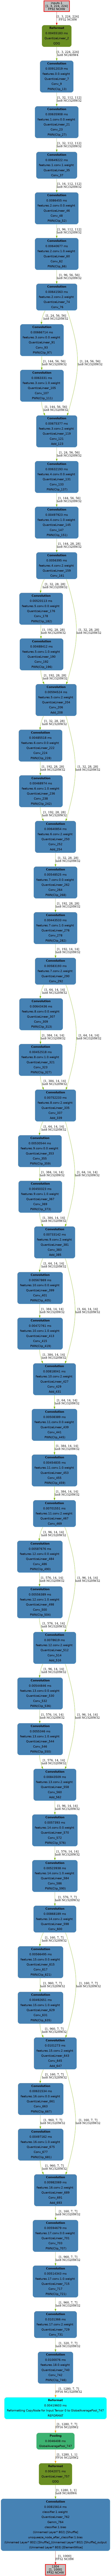

In [22]:
png_name = render_dot(graph, engine_name, 'png')
from IPython.display import Image
display(Image(filename=png_name))

## Convolution Layers

Sometimes it is interesting to look at all layers of a certain type. You can use Pandas' API (e.g. `query`) to slice the dataframe by layer type:

In [23]:
convs1 = plan.df.query("type == 'Convolution'")
convs2 = df[df.type == 'Convolution']

However, `trex` provides a `get_layers_by_type` API which performs some layer-type-specific preprocessing which is often useful. In the case of convolutions,

In [24]:
convs = plan.get_layers_by_type('Convolution')
display_df(convs)

plotly_bar2(
    convs, 
    "Latency Per Layer (%)<BR>(bar color indicates precision)",
    "attr.arithmetic_intensity", "Name",
    color='precision', 
    colormap=precision_colormap)

plotly_bar2(
    convs,
    "Convolution Data Sizes<BR>(bar color indicates latency)",
    "total_io_size_bytes", 
    "Name", 
    color='latency.pct_time')

Address already in use
Port 40001 is in use by another program. Either identify and stop that program, or start the server with a different port.


### Arithmetic Intensity

Arithmetic intensity (AI) is a measure of the amount of compute expended per data byte. Layers with higher AI are in general more efficient because moving data is much slower than computing an operation.  For each unit of data fetched from memory we want to perform many computations, because the GPU can compute much faster than it can fetch data from memory.  From more on AI, see https://en.wikipedia.org/wiki/Roofline_model#Arithmetic_intensity.<br>
This is a simplistic model which assumes that we read the data only once, and write it out once. In practice, when computing Convolution and GEMM operations, memory tiles are read several times, usually from fast shared-memory, L1 or L2 cached memory.

In [25]:
plotly_bar2(
    convs, 
    "Convolution Arithmetic Intensity<BR>(bar color indicates activations size)",
    "attr.arithmetic_intensity", 
    "Name",
    color='total_io_size_bytes')

plotly_bar2(
    convs, 
    "Convolution Arithmetic Intensity<BR>(bar color indicates latency)", 
    "attr.arithmetic_intensity", 
    "Name",
    color='latency.pct_time')

### Efficiency

Another simplistic model measures the compute and memory efficiency.  These indicators are calculated by taking the number of operations (or memory bytes) and dividing by the layer's execution time. 

In [26]:
# Memory accesses per ms (assuming one time read/write penalty)
plotly_bar2(
    convs, 
    "Convolution Memory Efficiency<BR>(bar color indicates latency)", 
    "attr.memory_efficiency", 
    "Name", 
    color='latency.pct_time')

# Compute operations per ms (assuming one time read/write penalty)
plotly_bar2(
    convs, 
    "Convolution Compute Efficiency<BR>(bar color indicates latency)",
    "attr.compute_efficiency",
    "Name",
    color='latency.pct_time')

### Statistics

In [27]:
convs = plan.get_layers_by_type('Convolution')

charts = []
convs_count_by_type = group_count(convs, 'subtype')
charts.append((convs_count_by_type, 'Count', 'count', 'subtype'))

convs_time_pct_by_type = group_sum_attr(convs, grouping_attr='subtype', reduced_attr='latency.pct_time')
charts.append((convs_time_pct_by_type, '% Latency Budget', 'latency.pct_time', 'subtype'))
plotly_pie2("Convolutions Statistics (Subtype)", charts)


charts = []
convs_count_by_group_size = group_count(convs, 'attr.groups')
charts.append((convs_count_by_group_size, 'Count', 'count', 'attr.groups'))

convs_time_pct_by_grp_size = group_sum_attr(convs, grouping_attr='attr.groups', reduced_attr='latency.pct_time')
charts.append((convs_time_pct_by_grp_size, '% Latency Budget', 'latency.pct_time', 'attr.groups'))
plotly_pie2("Convolutions Statistics (Number of Groups)", charts)



charts = []
convs_count_by_kernel_shape = group_count(convs, 'attr.kernel')
charts.append((convs_count_by_kernel_shape, 'Count', 'count', 'attr.kernel'))

convs_time_pct_by_kernel_shape = group_sum_attr(convs, grouping_attr='attr.kernel', reduced_attr='latency.pct_time')
charts.append((convs_time_pct_by_kernel_shape, '% Latency Budget', 'latency.pct_time', 'attr.kernel'))
plotly_pie2("Convolutions Statistics (Kernel Size)", charts)


charts = []
convs_count_by_precision = group_count(convs, 'precision')
charts.append((convs_count_by_precision, 'Count', 'count', 'precision'))

convs_time_pct_by_precision = group_sum_attr(convs, grouping_attr='precision', reduced_attr='latency.pct_time')
charts.append((convs_time_pct_by_precision, '% Latency Budget', 'latency.pct_time', 'precision'))

plotly_pie2("Convolutions Statistics (Precision)", charts, colormap=precision_colormap)